In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import json
import numpy as np
from rmab.utils import get_results_matching_parameters, filter_pareto_optimal
from rmab.plots import plot_line_plot_parameter, plot_tradeoff_curve, process_two_parameter_data, process_one_parameter_data, process_zero_parameter_data, aggregate_data
import seaborn as sns
import itertools 

In [3]:
plt.style.use('ggplot')

In [4]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
method_to_nice = {
    'random_rewards': 'Random',
    'optimal_rewards': 'Whittle (Oracle)',
    'wiql_rewards': 'WIQL', 
    'ucw_perfect_rewards': 'Approx. Whittle + Known Distance (Oracle)',
    'extreme_rewards': 'Extreme', 
    'ucb_rewards': 'UCB', 
    'ucb_fixed_rewards': 'UCB w/o Normal',
    'fixed_rewards': 'UCB w/o Normal',
    'norm_rewards': 'UCB + Normal.',
    'predicted_optimal_match_rewards': 'UCB Match',
    'qp_fixed_rewards': 'QP',
    'value_fixed_rewards': 'Value',
    'optimal_match_rewards': 'Whittle Match (Oracle)',
    'whittle_approximate_rewards': 'Whittle Approx. Match (Oracle)',
    'zero_step_rewards': 'Myopic Zero-Step', 
    'one_step_rewards': 'Myopic One-Step',
    'infinite_step_rewards': 'Myopic Infinite-Step',
    'combined_rewards': 'Combined',
    'ucw_match_rewards': 'UCW + Whittle Match'
}

match_to_nice = {
    'random_match': 'Random',
    'optimal_match': 'Optimal',
    'wiql_match': 'WIQL', 
    'extreme_match': 'Extreme', 
    'ucb_match': 'UCB', 
    'fixed_match': 'Fixed',
    'qp_match': 'QP',
    'value_match': 'Value', 
}

## Baseline Bandit

In [ ]:
seeds = [42,43,44]
data = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data = sorted(data,key=lambda k: k['parameters']['seed'])
full_data = {}
for i in data[0]['mean_reward']:
    mean_val = np.round(np.mean([j['mean_reward'][i] for j in data]),2)
    std_val = np.round(np.std([j['mean_reward'][i] for j in data]),2)
    full_data[i] = (mean_val,std_val)

for m in method_to_nice:
    if m in full_data:
        full_data[method_to_nice[m]] = full_data.pop(m)

matching_performance = {}
for i in data[0]['match_rate']:
    mean_val = np.mean([j['match_rate'][i] for j in data])
    std_val = np.std([j['match_rate'][i] for j in data])
    matching_performance[i] = (mean_val,std_val)

for m in match_to_nice:
    if m in matching_performance:
        matching_performance[match_to_nice[m]] = matching_performance.pop(m)


In [ ]:
latex_table = f"""
\\begin{{table}}
    \\centering
    \\begin{{tabular}}{{@{{}}lccc@{{}}}}
        \\toprule
        Algorithm & \\multicolumn{{1}}{{c}}{{Bandit Perf.}} & \\multicolumn{{1}}{{c}}{{Matching Perf.}} \\\\ 
        \\midrule
"""

for algorithm in full_data.keys():
    bandit_value, bandit_error = full_data[algorithm]
    matching_value, matching_error = matching_performance.get(algorithm, (0, 0))
    
    latex_table += f"        {algorithm} & ${bandit_value:.2f} \\pm {bandit_error:.2f}$ & ${matching_value:.3f} \\pm {matching_error:.3f}$ \\\\ \n"

latex_table += """
        \\bottomrule
    \end{tabular}
    \\caption{Bandit and Matching Performance}
\\end{table}
"""

print(latex_table)


In [ ]:
data = get_results_matching_parameters("baseline","hyperparameter",{'budget': 3})
plot_line_plot_parameter(data,'n_arms','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_arms.pdf")


In [ ]:
plot_line_plot_parameter(data,'n_arms','match_rate',match_to_nice)
plt.yticks([0.95,0.96,0.97,0.98,0.99,1.00],['95%','96%','97%','98%','99%','100%'])
plt.xticks([4,8,12,16])
sns.despine()
plt.legend()
plt.xlabel("Cohort Size")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_arms.pdf")


In [ ]:
data = get_results_matching_parameters("baseline","hyperparameter",{'n_arms': 8})
plot_line_plot_parameter(data,'budget','mean_reward',method_to_nice)
plt.yticks([2,3,4,5])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Reward")
plt.savefig("../figures/baseline/reward_budget.pdf")


In [ ]:
plot_line_plot_parameter(data,'budget','match_rate',match_to_nice)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.00],['90%','92%','94%','96%','98%','100%'])
plt.xticks([2,4,6])
sns.despine()
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Match Rate")
plt.savefig("../figures/baseline/match_budget.pdf")

## Semi Synthetic Experiments

Text(0, 0.5, 'Total Reward')

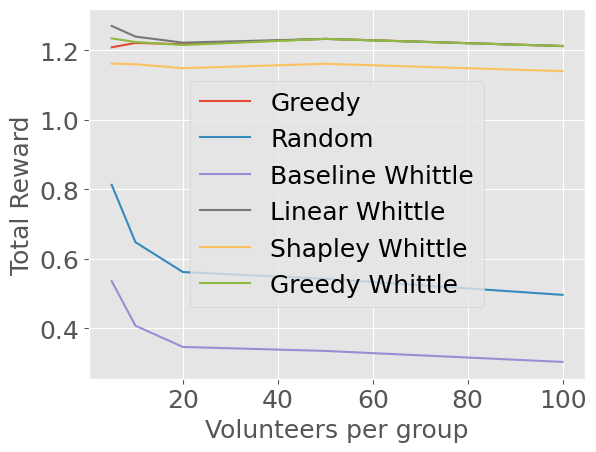

In [49]:
method_names = ['greedy','random','whittle_engagement','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
n_values = [5,10,20,50,100]

for i,m in enumerate(method_names):
    score_by_n = []
    for n in n_values:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': n, 'lamb': 1/(n*2), 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_n.append(results['{}_match'.format(m)][0] + results['{}_active'.format(m)][0])
    plt.plot(n_values,score_by_n,label=nice_names[i])
plt.legend()
plt.xlabel("Volunteers per group")
plt.ylabel("Total Reward")

Text(0, 0.5, 'Total Reward')

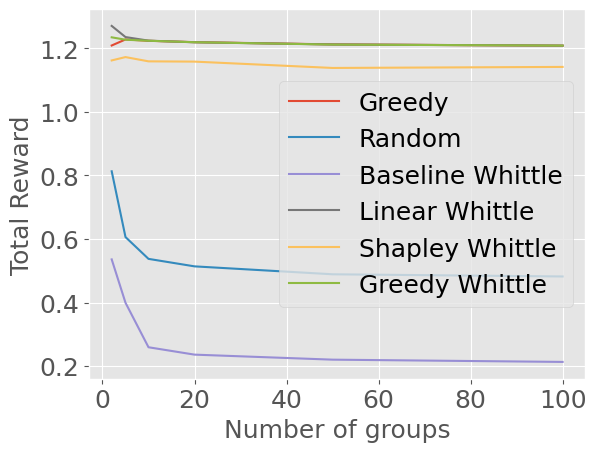

In [50]:
method_names = ['greedy','random','whittle_engagement','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
g_values = [2,5,10,20,50,100]

for i,m in enumerate(method_names):
    score_by_g = []
    for g in g_values:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': 5, 'lamb': 1/(5*g), 'budget': 3, 'prob_distro': 'uniform', 'n_arms': g})
        results = aggregate_data(results)
        
        score_by_g.append(results['{}_match'.format(m)][0] + results['{}_active'.format(m)][0])
    plt.plot(g_values,score_by_g,label=nice_names[i])
plt.legend()
plt.xlabel("Number of groups")
plt.ylabel("Total Reward")

Text(0, 0.5, 'Total Reward')

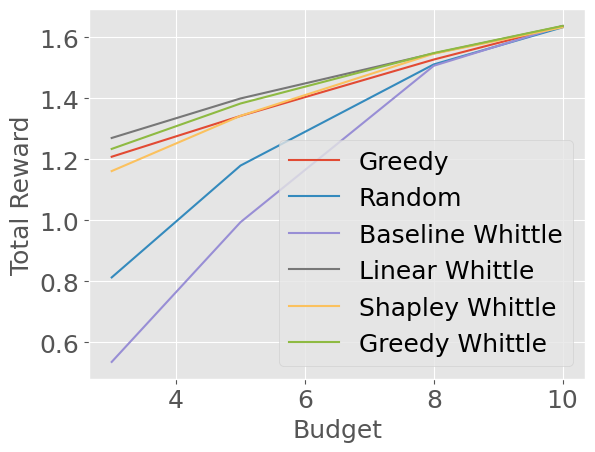

In [51]:
method_names = ['greedy','random','whittle_engagement','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
budget = [3,5,8,10]

for i,m in enumerate(method_names):
    score_by_budget = []
    for b in budget:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': 5, 'lamb': 1/(5*2), 'budget': b, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        
        score_by_budget.append(results['{}_match'.format(m)][0] + results['{}_active'.format(m)][0])
    plt.plot(budget,score_by_budget,label=nice_names[i])
plt.legend()
plt.xlabel("Budget")
plt.ylabel("Total Reward")

Text(0, 0.5, 'Total Reward')

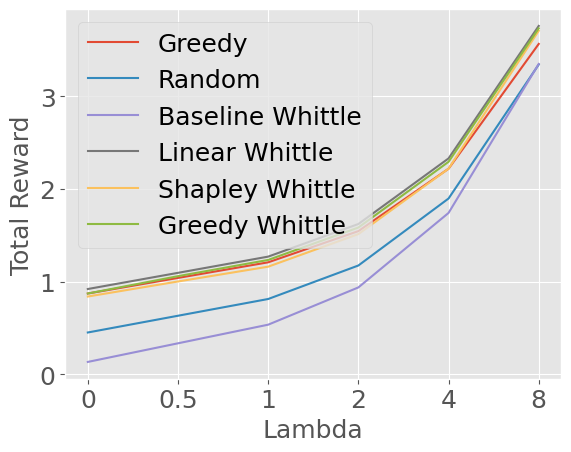

In [52]:
method_names = ['greedy','random','whittle_engagement','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
lamb = [0,0.5,1,2,4,8]

for i,m in enumerate(method_names):
    score_by_lamb = []
    for l in lamb:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': 5, 'lamb': float(l/(5*2)), 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        score_by_lamb.append(results['{}_match'.format(m)][0] + l*results['{}_active'.format(m)][0])
    plt.plot(list(range(len(score_by_lamb))),score_by_lamb,label=nice_names[i])
plt.xticks(list(range(len(score_by_lamb))),labels=[str(i) for i in lamb])
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("Total Reward")

Text(0, 0.5, 'Total Reward')

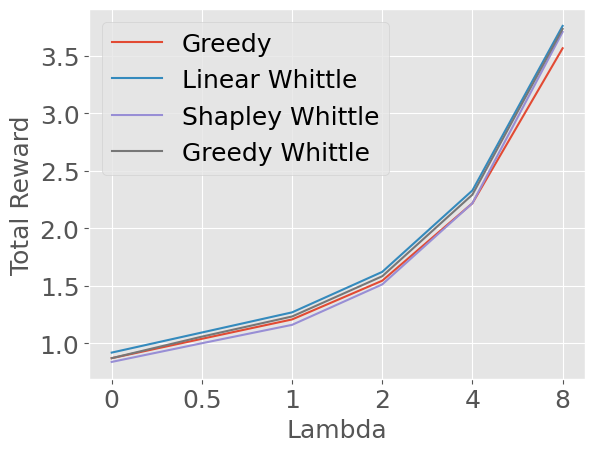

In [58]:
method_names = ['greedy','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Linear Whittle","Shapley Whittle","Greedy Whittle"]
lamb = [0,0.5,1,2,4,8]

for i,m in enumerate(method_names):
    score_by_lamb = []
    for l in lamb:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': 5, 'lamb': float(l/(5*2)), 'budget': 3, 'prob_distro': 'uniform', 'n_arms': 2})
        results = aggregate_data(results)
        score_by_lamb.append(results['{}_match'.format(m)][0] + l*results['{}_active'.format(m)][0])
    plt.plot(list(range(len(score_by_lamb))),score_by_lamb,label=nice_names[i])
plt.xticks(list(range(len(score_by_lamb))),labels=[str(i) for i in lamb])
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("Total Reward")

Text(0, 0.5, 'Total Reward')

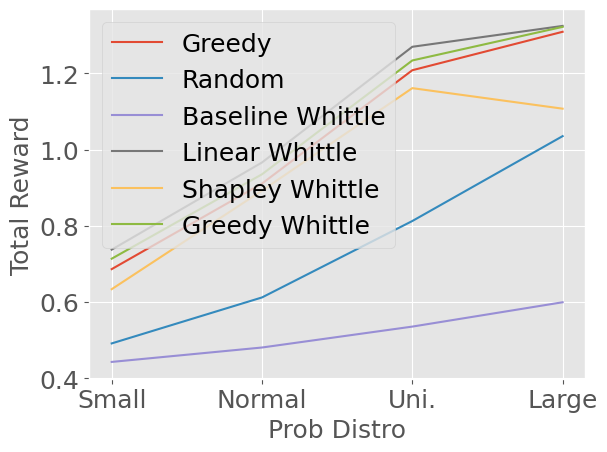

In [59]:
method_names = ['greedy','random','whittle_engagement','linear_whittle','shapley_whittle','whittle_greedy']
nice_names = ["Greedy","Random","Baseline Whittle","Linear Whittle","Shapley Whittle","Greedy Whittle"]
prob_distro = ['uniform_small','normal','uniform','uniform_large']
prob_distro_nice = ["Small","Normal","Uni.","Large"]

for i,m in enumerate(method_names):
    score_by_prob = []
    for p in prob_distro:
        results = get_results_matching_parameters("semi_synthetic","",{'volunteers_per_arm': 5, 'lamb': 1/10, 'budget': 3, 'prob_distro': p, 'n_arms': 2})
        results = aggregate_data(results)
        score_by_prob.append(results['{}_match'.format(m)][0] + results['{}_active'.format(m)][0])
    plt.plot(list(range(len(score_by_prob))),score_by_prob,label=nice_names[i])
plt.xticks(list(range(len(score_by_prob))),labels=prob_distro_nice)
plt.legend()
plt.xlabel("Prob Distro")
plt.ylabel("Total Reward")

## Improving Bandits

In [ ]:
data_synthetic = get_results_matching_parameters("replication","synthetic",{})
data_fr = get_results_matching_parameters("baseline","results",{'n_arms': 8, 'budget': 3})
data_better = get_results_matching_parameters("better_bandit","normal",{})


synthetic_data = []
fr_data = []

synthetic_data.append(np.mean([np.mean(i['mean_rewards']['ucw_ucb']) for i in data_synthetic]))
synthetic_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-synthetic_data[0])
synthetic_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])-(synthetic_data[1]+synthetic_data[0]))
synthetic_data_optimal = np.mean([i['mean_optimal_reward'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])
synthetic_data_perfect= np.mean([i['mean_reward_perfect'] for i in data_better if i['parameters']['dataset'] == 'synthetic'])

fr_data.append(np.mean([i['mean_reward']['ucb_rewards'] for i in data_fr]))
fr_data.append(np.mean([i['mean_reward_baseline'] for i in data_better if i['parameters']['dataset'] == 'fr'])-fr_data[0])
fr_data.append(np.mean([i['mean_reward_norm'] for i in data_better if i['parameters']['dataset'] == 'fr'])-(fr_data[1]+fr_data[0]))
fr_data_optimal = np.mean([i['mean_optimal_reward'] for i in data_better if i['parameters']['dataset'] == 'fr'])
fr_data_perfect = np.mean([i['mean_reward_perfect'] for i in data_better if i['parameters']['dataset'] == 'fr'])


In [ ]:
colors = ['#87CEEB', '#FFFF99', '#FFA07A']  # Pastel Blue, Yellow, and Red
labels = ['UCB','Fixed','Normal']


# Create a figure and axis
fig, ax = plt.subplots(figsize=(6,6))

# Create a stacked bar chart for the data
bottom = 0
for i, value in enumerate(synthetic_data):
    ax.bar(0, value, color=colors[i], bottom=bottom,label=labels[i])
    bottom += value

bottom = 0
for i, value in enumerate(fr_data):
    ax.bar(1, value, color=colors[i], bottom=bottom)
    bottom += value


# Customize labels and legend
ax.set_xticks([0,1])
ax.set_xticklabels(['Synthetic','Food'])
ax.set_xlabel('Dataset')
ax.set_ylabel('Reward')

ax.axhline(synthetic_data_optimal, color='green', linestyle='--',xmin=-0.5,xmax=0.5,label='Optimal')
ax.axhline(synthetic_data_perfect, color='black', linestyle='--',xmin=-0.5,xmax=0.5,label='Max. Whittle Estimate')


ax.axhline(fr_data_optimal, color='green', linestyle='--',xmin=0.5,xmax=1.5)
ax.axhline(fr_data_perfect, color='black', linestyle='--',xmin=0.5,xmax=1.5)

plt.legend()
plt.savefig("../figures/better_bandit/normal_improvement.pdf")

## Matching Performance

In [ ]:
data_matching = get_results_matching_parameters("matching","p_val",{})
avg_reward_by_method = {}
all_p_vals = sorted(list(set([i['parameters']['match_prob'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for p in all_p_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['match_prob'] == p]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_p_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Matching Probability")
plt.ylabel("Claim Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_p.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.xticks([4,6,8])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_baseline_n_arms.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8,0.85], ["75%", "80%", "85%"])
plt.ylim([0.73,0.86])
plt.xticks([4,6,8])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_baseline_n_arms_zoomed.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=method_to_nice[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8], ["75%", "80%"])
plt.ylim([0.73,0.82])
plt.xticks([4,5,6])
plt.legend()

plt.savefig("../figures/matching/matching_baseline_n_arms_zoomed_2.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching_baseline","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

for i in avg_reward_by_method:
    for j in range(len(avg_reward_by_method[i])):
        avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=method_to_nice[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match% of Optimal')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

plt.savefig("../figures/matching/matching_baseline_bar.pdf")

avg_reward_by_method

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method.lower():
        pass 
    else:
        labels[method] += ' est.'

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=labels[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
plt.xticks([4,6,8])
plt.legend(loc='lower left')

plt.savefig("../figures/matching/matching_estimated_n_arms.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}
all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    if i not in ['zero_step_rewards','one_step_rewards','infinite_step_rewards','ucw_match_rewards',
    'ucw_perfect_rewards','whittle_approximate_rewards','optimal_match_rewards']:
        print(i)
        continue 

    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

line_styles = ['-', '--', ':']
line_style_cycle = itertools.cycle(line_styles)

plt.figure(figsize=(8, 8))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method.lower():
        pass 
    else:
        labels[method] += ' est.'

for method in avg_reward_by_method:
    style = next(line_style_cycle)
    plt.plot(all_n_arm_vals, avg_reward_by_method[method], label=labels[method], linestyle=style)

plt.xlabel("Number of Arms")
plt.ylabel("Match Rate")
plt.yticks([0.75,0.8,0.85], ["75%", "80%", "85%"])
plt.ylim([0.73,0.86])
plt.xticks([4,5,6])
plt.legend(fontsize=14)

plt.savefig("../figures/matching/matching_estimated_n_arms_zoomed.pdf")

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

for i in avg_reward_by_method:
    for j in range(len(avg_reward_by_method[i])):
        avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method_to_nice[method].lower():
        pass 
    else:
        labels[method] += ' est.'

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=labels[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match% of Optimal')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

plt.savefig("../figures/matching/matching_estimated_bar.pdf")

avg_reward_by_method

In [ ]:
data_matching = get_results_matching_parameters("matching","results",{})
data_matching = [i for i in data_matching if i['parameters']['n_arms']<=6]
avg_reward_by_method = {}

all_n_arm_vals = sorted(list(set([i['parameters']['n_arms'] for i in data_matching])))

for i in data_matching[0]['mean_reward'].keys():
    if i not in ['optimal_match_rewards','ucw_match_rewards','ucw_perfect_rewards']:
        continue 
    avg_reward_by_method[i] = []

    for n in all_n_arm_vals:
        results_p = [data['mean_reward'][i] for data in data_matching if data['parameters']['n_arms'] == n]
        avg_reward_by_method[i].append(np.mean(results_p))

# for i in avg_reward_by_method:
#     for j in range(len(avg_reward_by_method[i])):
#         avg_reward_by_method[i][j] /= avg_reward_by_method['optimal_match_rewards'][j]

categories = list(avg_reward_by_method.keys())
values = np.array(list(avg_reward_by_method.values()))

# Determine the number of bars
num_bars = len(avg_reward_by_method[categories[0]])

# Set the bar width and spacing
bar_width = 0.2
bar_spacing = 0

# Calculate the x-positions for each set of bars
x = np.arange(num_bars)*2

# Set up the color palette for the legend
color_palette = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

# Create the paired bar chart
fig, ax = plt.subplots(figsize=(10,10))

labels = {}
for method in avg_reward_by_method:
    labels[method] = method_to_nice[method]
    if 'random' in method.lower() or 'oracle' in method_to_nice[method].lower():
        pass 
    else:
        labels[method] += ' est.'

for i, category in enumerate(categories):
    ax.bar(x + (i - (len(categories) - 1) / 2) * (bar_width + bar_spacing), values[i], width=bar_width, label=labels[category], color=color_palette[i])

# Customize the plot
ax.set_xlabel('')
plt.xticks(x,all_n_arm_vals)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel('Match%')
ax.set_xlabel("Number of Arms")

plt.legend(loc='lower left') 

avg_reward_by_method

## Activity vs. Matching Tradeoff

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","sufficient","joint"]
nice_names = ["Whittle","Sufficient Q Iteration","Optimal"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 7
names = ["whittle","sufficient"]
nice_names = ["Whittle","Sufficient Q Iteration"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","sufficient"]
nice_names = ["Whittle","Sufficient Q Iteration"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","results",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","sufficient","neural"]
nice_names = ["Whittle","Sufficient Q Iteration","PPO"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

## New Matching + Engagement Results

In [ ]:
combined = get_results_matching_parameters("combined","heterogeneous_arms",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","joint","greedy"]
nice_names = ["Whittle","Optimal","Greedy"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","heterogeneous_arms",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","joint","greedy","iterative","iterative_q"]
nice_names = ["Whittle","Optimal","Greedy","Iterative","Iterative + Q"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","heterogeneous_arms",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","joint","iterative_q","iterative_shapley","iterative_q_shapley"]
nice_names = ["Whittle","Optimal","Iterative + Q","Iterative+Shapley","Iterative + Q + Shapley"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","heterogeneous_arms",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","joint","mcts","mcts_q"]
nice_names = ["Whittle","Optimal","MCTS","MCTS+Q Iteration"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

In [ ]:
combined = get_results_matching_parameters("combined","heterogeneous_arms",{})
data_by_arms = process_one_parameter_data(combined,"n_arms")

n_arms = 4
names = ["whittle","joint","mcts","iterative","greedy"]
nice_names = ["Whittle","Optimal","MCTS","Iterative","Greedy"]
plot_tradeoff_curve(data_by_arms[n_arms],names,nice_names,"N Arms {}".format(n_arms))

## Large N Matching Results

whittle Combined Whittle
whittle_activity Pure Whittle
whittle_whittle Double Whittle
greedy Greedy
shapley_whittle Shapley+Whittle
whittle_greedy Greedy+Whittle
optimal Optimal


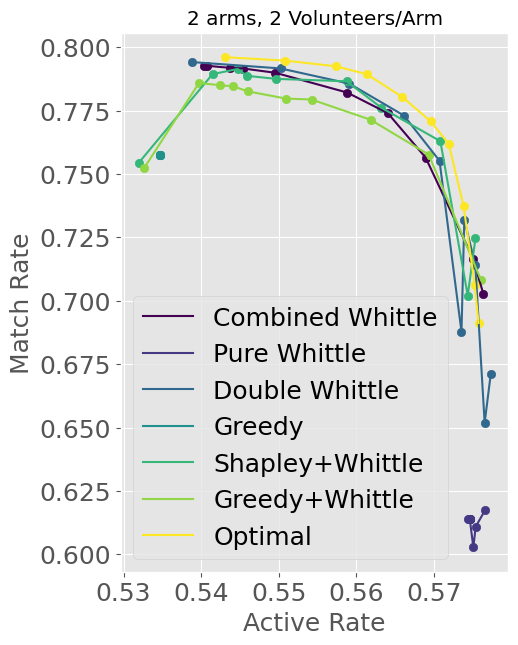

In [9]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")

n_arms = 2
n_volunteers = 2

names = ["whittle","whittle_activity","whittle_whittle","greedy","shapley_whittle","whittle_greedy"]
nice_names = ["Combined Whittle","Pure Whittle","Double Whittle","Greedy","Shapley+Whittle","Greedy+Whittle"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle Combined Whittle
whittle_activity Pure Whittle
whittle_whittle Double Whittle
greedy Greedy
shapley_whittle Shapley+Whittle
whittle_greedy Greedy+Whittle


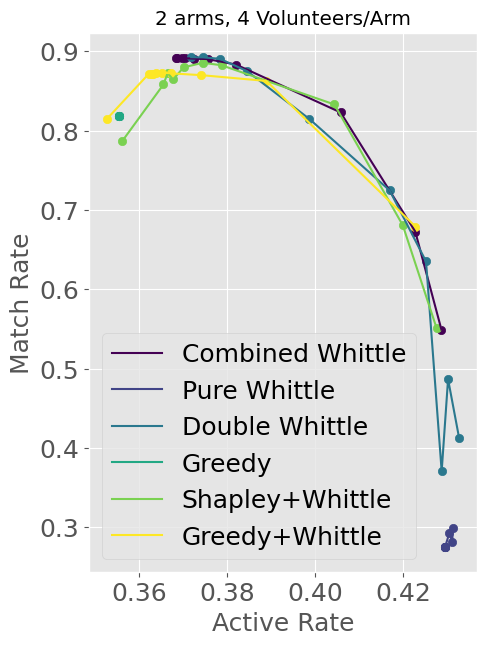

In [11]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")

n_arms = 2
n_volunteers = 4

names = ["whittle","whittle_activity","whittle_whittle","greedy","shapley_whittle","whittle_greedy"]
nice_names = ["Combined Whittle","Pure Whittle","Double Whittle","Greedy","Shapley+Whittle","Greedy+Whittle"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle Combined Whittle
greedy Greedy
whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS Two Step
optimal Optimal


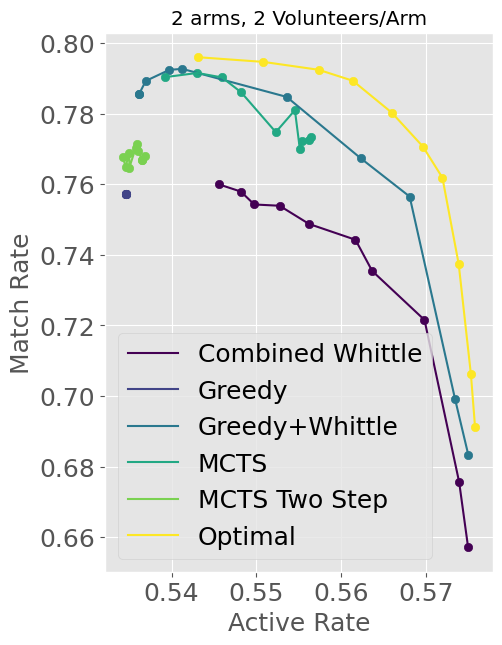

In [7]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
combined = get_results_matching_parameters("combined_large","mcts",{})
data_by_arm_volunteer_2 = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
for i in data_by_arm_volunteer_2:
    for j in data_by_arm_volunteer_2[i]:
        for k in data_by_arm_volunteer_2[i][j]:
            data_by_arm_volunteer[i][j][k] = data_by_arm_volunteer_2[i][j][k]

n_arms = 2
n_volunteers = 2

names = ["whittle","greedy","whittle_greedy","mcts","mcts_mcts"]
nice_names = ["Combined Whittle","Greedy","Greedy+Whittle","MCTS","MCTS Two Step"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle Combined Whittle
whittle_activity Pure Whittle
greedy Greedy
shapley_whittle Shapley+Whittle
whittle_greedy Greedy+Whittle


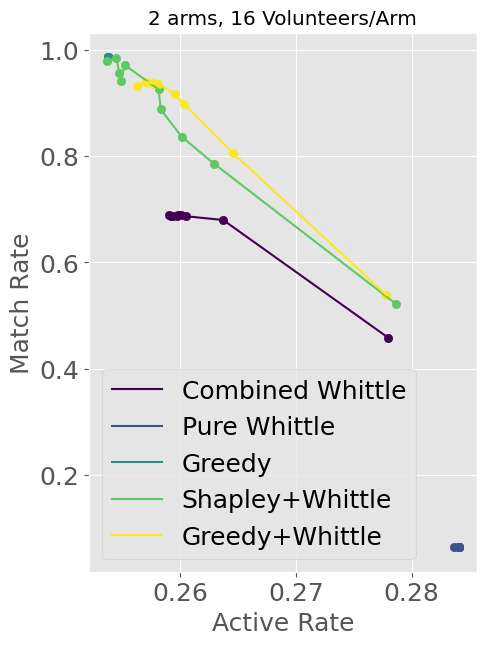

In [8]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")

n_arms = 2
n_volunteers = 16

names = ["whittle","whittle_activity","greedy","shapley_whittle","whittle_greedy"]
nice_names = ["Combined Whittle","Pure Whittle","Greedy","Shapley+Whittle","Greedy+Whittle"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle Combined Whittle
greedy Greedy
whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS Two Step


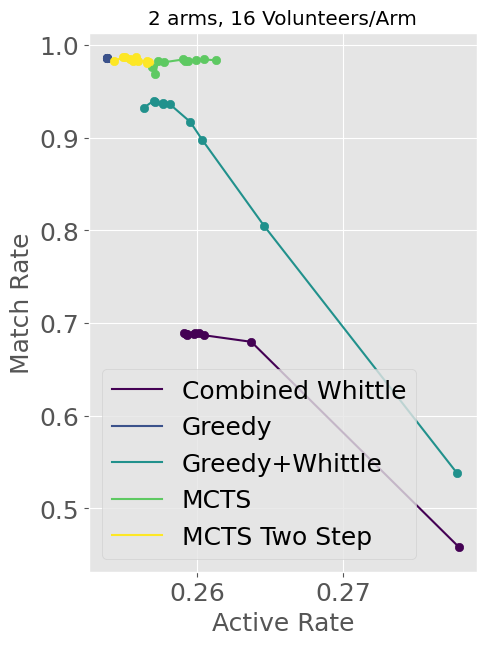

In [11]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
combined = get_results_matching_parameters("combined_large","mcts",{})
data_by_arm_volunteer_2 = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
for i in data_by_arm_volunteer_2:
    for j in data_by_arm_volunteer_2[i]:
        for k in data_by_arm_volunteer_2[i][j]:
            data_by_arm_volunteer[i][j][k] = data_by_arm_volunteer_2[i][j][k]

n_arms = 2
n_volunteers = 16

names = ["whittle","greedy","whittle_greedy","mcts","mcts_mcts"]
nice_names = ["Combined Whittle","Greedy","Greedy+Whittle","MCTS","MCTS Two Step"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

In [ ]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")

n_arms = 16
n_volunteers = 2

names = ["whittle","greedy","shapley_whittle","whittle_greedy"]
nice_names = ["Combined Whittle","Greedy","Shapley+Whittle","Greedy+Whittle"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle Combined Whittle
greedy Greedy
whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS Two Step


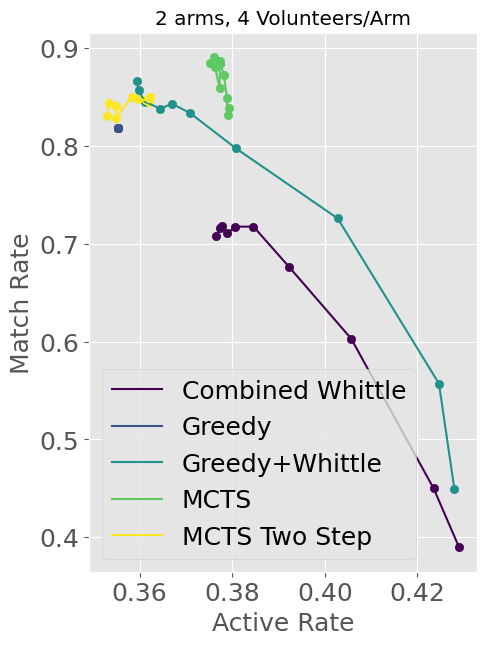

In [13]:
combined = get_results_matching_parameters("combined_large","combined",{})
data_by_arm_volunteer = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
combined = get_results_matching_parameters("combined_large","mcts",{})
data_by_arm_volunteer_2 = process_two_parameter_data(combined,"n_arms","volunteers_per_arm")
for i in data_by_arm_volunteer_2:
    for j in data_by_arm_volunteer_2[i]:
        for k in data_by_arm_volunteer_2[i][j]:
            data_by_arm_volunteer[i][j][k] = data_by_arm_volunteer_2[i][j][k]

n_arms = 2
n_volunteers = 4

names = ["whittle","greedy","whittle_greedy","mcts","mcts_mcts"]
nice_names = ["Combined Whittle","Greedy","Greedy+Whittle","MCTS","MCTS Two Step"]

if n_arms * n_volunteers <= 6:
    names.append("optimal")
    nice_names.append("Optimal")

plot_tradeoff_curve(data_by_arm_volunteer[n_arms][n_volunteers],names,nice_names,"{} arms, {} Volunteers/Arm".format(n_arms,n_volunteers))

whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS+MCTS Two Step
mcts_whittle Greedy+MCTS Two Step


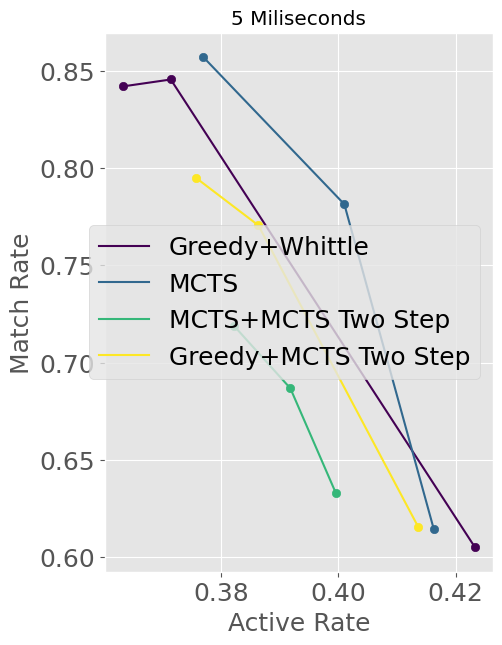

In [14]:
combined = get_results_matching_parameters("combined_large","two_step",{})
data_by_time = process_one_parameter_data(combined,"time_per_run")

names = ["whittle_greedy","mcts","mcts_mcts","mcts_whittle"]
nice_names = ["Greedy+Whittle","MCTS","MCTS+MCTS Two Step","Greedy+MCTS Two Step"]

plot_tradeoff_curve(data_by_time[5],names,nice_names,"5 Miliseconds")

whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS+MCTS Two Step
mcts_whittle Greedy+MCTS Two Step


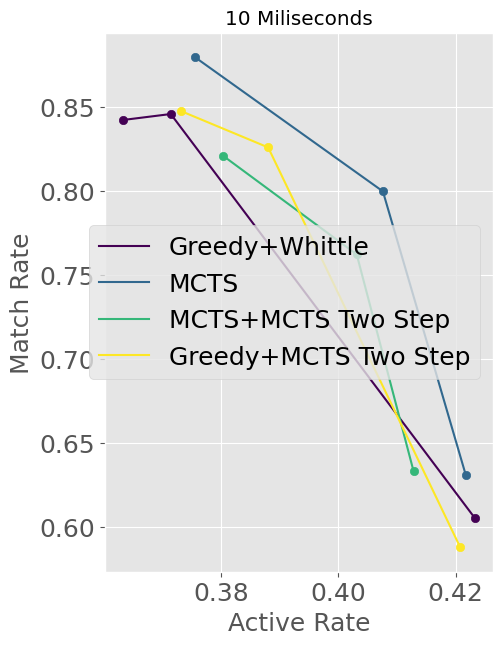

In [15]:
combined = get_results_matching_parameters("combined_large","two_step",{})
data_by_time = process_one_parameter_data(combined,"time_per_run")

names = ["whittle_greedy","mcts","mcts_mcts","mcts_whittle"]
nice_names = ["Greedy+Whittle","MCTS","MCTS+MCTS Two Step","Greedy+MCTS Two Step"]

plot_tradeoff_curve(data_by_time[10],names,nice_names,"10 Miliseconds")

whittle_greedy Greedy+Whittle
mcts MCTS
mcts_mcts MCTS+MCTS Two Step
mcts_whittle Greedy+MCTS Two Step


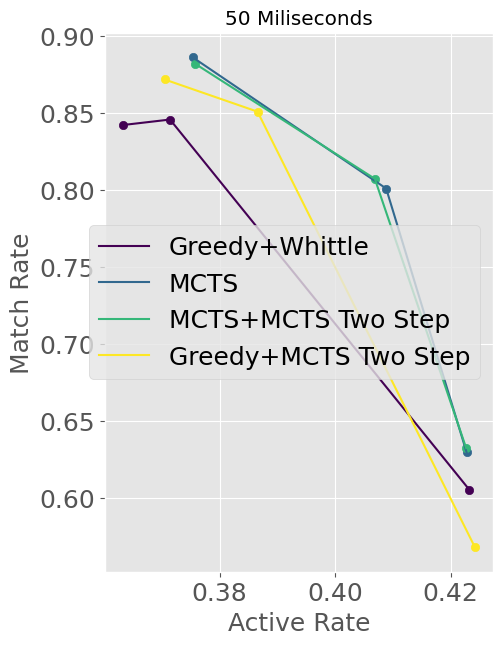

In [6]:
combined = get_results_matching_parameters("combined_large","two_step",{})
data_by_time = process_one_parameter_data(combined,"time_per_run")

names = ["whittle_greedy","mcts","mcts_mcts","mcts_whittle"]
nice_names = ["Greedy+Whittle","MCTS","MCTS+MCTS Two Step","Greedy+MCTS Two Step"]

plot_tradeoff_curve(data_by_time[50],names,nice_names,"50 Miliseconds")

## Time on Real World Data

(33.027709363394, 33.04089999999135)

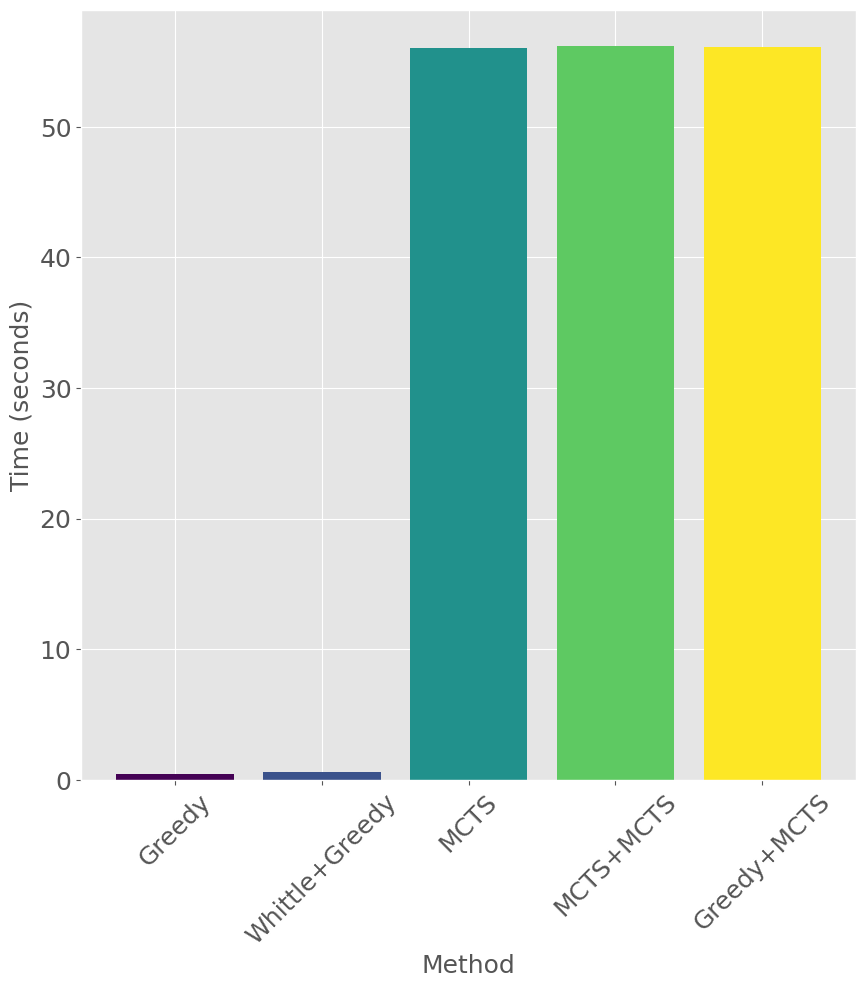

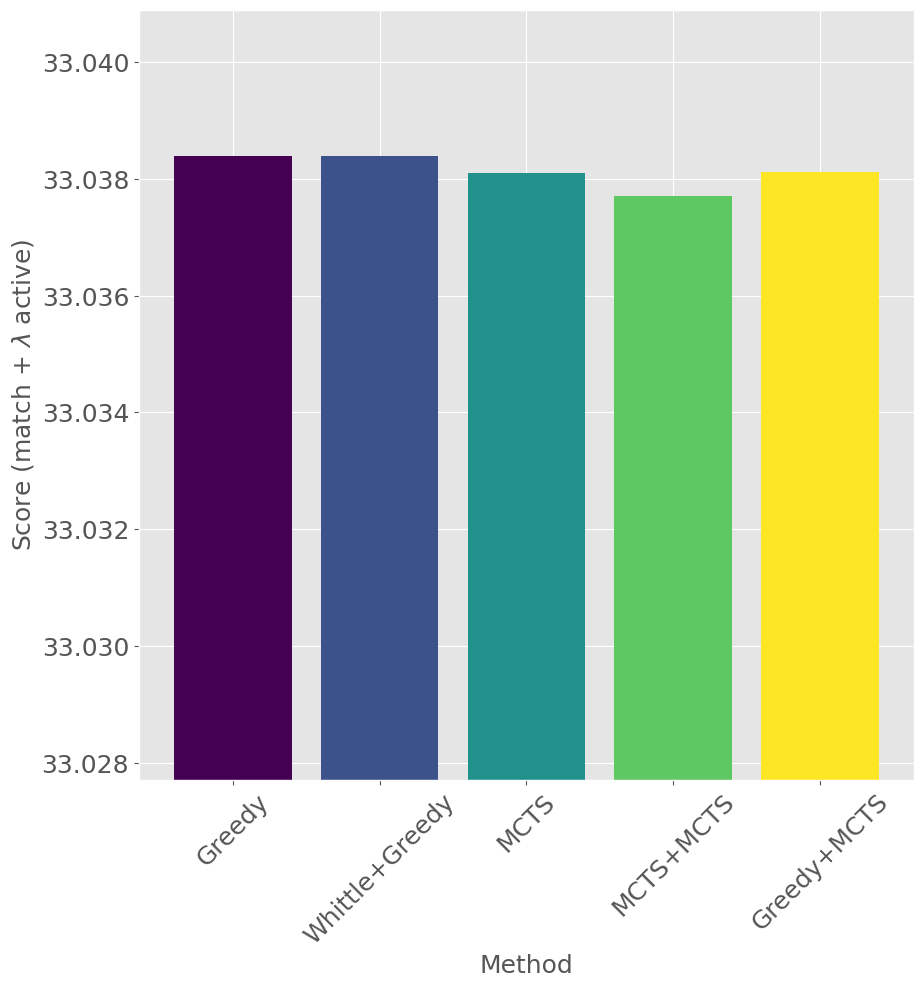

In [23]:
names = ["greedy","whittle_greedy","mcts","mcts_mcts","mcts_whittle"]
nice_names = ["Greedy","Whittle+Greedy","MCTS","MCTS+MCTS","Greedy+MCTS"]

combined = get_results_matching_parameters("combined_large","time",{})
data = process_zero_parameter_data(combined)
colors = plt.cm.viridis(np.linspace(0, 1, len(nice_names)))
time_data = [data["{}_time".format(i)] for i in names]
score_data = [data["{}_score".format(i)] for i in names]
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(time_data)):
    ax.bar(i, time_data[i], color=colors[i],label=nice_names[i])
plt.xlabel("Method")
plt.xticks(list(range(len(nice_names))),labels=nice_names,rotation=45)
plt.ylabel("Time (seconds)")

fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(time_data)):
    ax.bar(i, score_data[i], color=colors[i],label=nice_names[i])
plt.xlabel("Method")
plt.xticks(list(range(len(nice_names))),labels=nice_names,rotation=45)
plt.ylabel("Score (match + $\lambda$ active)")
plt.ylim([min(score_data)-.01,max(score_data)+.0025])
